# Amazon Food Review Dataset <p>
    Predicting helpfulness.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
%matplotlib inline

# Read Raw Data Train

In [23]:
amazon = pd.read_csv('/Users/Eduardo/Desktop/raw_data_train.csv')
print(amazon.shape)
print('**********')
print(amazon['Score'].mean())
print('**********')
print(amazon['Score'].median())
print('**********')
print(amazon['Score'].mode())

(364000, 14)
**********
4.183131868131868
**********
5.0
**********
0    5
dtype: int64


In [24]:
amazon.head(2)

,Unnamed: 0,Unnamed: 0.1,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpScore,helpful
0,392248,23559,23560,B000I4L5ZW,AU4E71CKR72M9,"V. E. EMSWILER ""mother of 5 / artist""",0,0,5,1271894400,Best Nacho Dip Ever!,This is the ONLY Nacho Cheese Dip I will eat! ...,NaN,False
1,203929,131036,131037,B0002L3BYE,A11I4LJOAOCJ5L,"larry jones ""the expert""",0,0,1,1341273600,They call it a dip!,"What are you supposed to dip into this, bread,...",NaN,False


# Features Creation <p>
Positivity, Negativity, Length

In [25]:
amazon['positivity'] = np.where(amazon['Score'] > 3,1,0)
amazon['negativity'] = np.where(amazon['Score'] < 3,1,0)
amazon['lenght'] = amazon['Text'].str.len()

amazon.head(3)

,Unnamed: 0,Unnamed: 0.1,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpScore,helpful,positivity,negativity,lenght
0,392248,23559,23560,B000I4L5ZW,AU4E71CKR72M9,"V. E. EMSWILER ""mother of 5 / artist""",0,0,5,1271894400,Best Nacho Dip Ever!,This is the ONLY Nacho Cheese Dip I will eat! ...,NaN,False,1,0,242
1,203929,131036,131037,B0002L3BYE,A11I4LJOAOCJ5L,"larry jones ""the expert""",0,0,1,1341273600,They call it a dip!,"What are you supposed to dip into this, bread,...",NaN,False,0,1,483
2,90525,239580,239581,B001E6K6B2,AD1HUS8ZWEWQK,S. Allen,0,0,5,1303948800,raison bran crunch cereal,"This is one of my favorite ""healthy"" cereals. ...",NaN,False,1,0,412


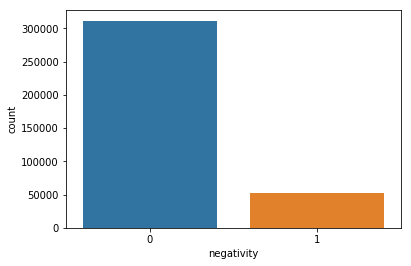

In [122]:
sns.countplot(amazon['negativity'])


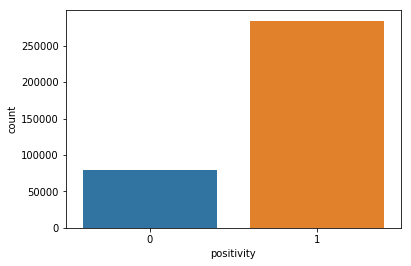

In [123]:
sns.countplot(amazon['positivity'])

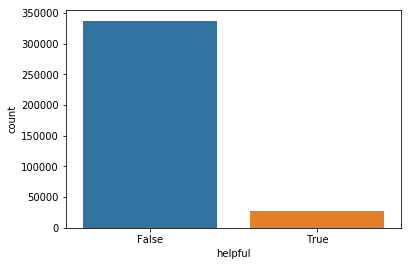

In [118]:
sns.countplot(amazon['helpful'])

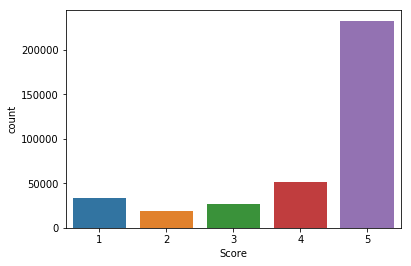

In [121]:
 sns.countplot(amazon['Score'])

#  Quantitative Feature Selection <p>


In [26]:
X_quant_features_ed = amazon[["Score","positivity", "lenght"]]
print(X_quant_features_ed.head(5))
print(type(X_quant_features_ed))

   Score  positivity  lenght
0      5           1     242
1      1           0     483
2      5           1     412
3      5           1     151
4      4           1     922
<class 'pandas.core.frame.DataFrame'>


# Featured Extraction

In [27]:
# Implement the transformer: Hashing Vectorizer
vectorizer = HashingVectorizer(n_features=2 ** 20, non_negative=True)
# encode
vector = vectorizer.transform(amazon.Text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
#Model Persistance
joblib.dump(vectorizer, 'vectorizer.pkl') # pickle

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 1048576)
<class 'scipy.sparse.csr.csr_matrix'>


['vectorizer.pkl']

# Tfid Transformer
According to the Scikit-learn documentation, one of the limitations of the Hashing Vectorizer is that it does not provide IDF weighting as that would introduce statefulness in the model. Thus, a TfidfTransformer can be appended to it in a pipeline if required. Let´s do that.

In [28]:
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(vector)
#Model Persistance
joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

# All quantitative features combined as a Sparse Matrix


In [29]:
X_quant_features_csr = csr_matrix(X_quant_features_ed)
X_combined = hstack([X_tfidf, X_quant_features_csr])
# convert to sparse matrix
X_matrix = csr_matrix(X_combined) 
print(X_matrix.shape)

(364000, 1048579)


In [30]:
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)
#Model Persistance
joblib.dump(sc, 'sc.pkl') # pickle

(364000, 1048579)


['sc.pkl']

In [31]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# Logistic A<p>
    Exploring alpha=0.001

In [32]:
logistic = linear_model.SGDClassifier(loss='log', alpha=0.001)
logistic.fit(X, y)
# Model Persistant
joblib.dump(logistic, 'logistic.pkl') # pickle

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


['logistic.pkl']

In [48]:
logistic_performance = BinaryClassificationPerformance(logistic.predict(X), y, 'A')
logistic_performance.compute_measures()
print(logistic_performance.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 13554, 'TN': 327089, 'FP': 10310, 'FN': 13047, 'Accuracy': 0.9358324175824175, 'Precision': 0.567968488099229, 'Recall': 0.509529716927935, 'desc': 'A'}


# Logistic B<p>
    
    Exploring alpha=0.01

In [130]:
logistic2 = linear_model.SGDClassifier(loss='log', alpha=0.01)
logistic2.fit(X, y)
# Model Persistant
joblib.dump(logistic2, 'logistic2.pkl') # pickle
# Performance
logistic_performance2 = BinaryClassificationPerformance(logistic2.predict(X), y, 'B')
logistic_performance2.compute_measures()
print(logistic_performance2.performance_measures)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26601, 'Neg': 337399, 'TP': 11964, 'TN': 335123, 'FP': 2276, 'FN': 14637, 'Accuracy': 0.9535357142857143, 'Precision': 0.8401685393258427, 'Recall': 0.44975752791248447, 'desc': 'B'}


{'Pos': 26601, 'Neg': 337399, 'TP': 12155, 'TN': 334963, 'FP': 2436, 'FN': 14446, 'Accuracy': 0.9536208791208791, 'Precision': 0.8330477691727778, 'Recall': 0.45693770910868015, 'desc': 'B'}


# Logistic C<p>
    Exploring alpha=0.000000001

In [76]:
logistic3 = linear_model.SGDClassifier(loss='log', alpha=0.000000001)
logistic3.fit(X, y)
# Model Persistant
joblib.dump(logistic3, 'logistic3.pkl') # pickle

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


['logistic3.pkl']

In [77]:
logistic_performance3 = BinaryClassificationPerformance(logistic3.predict(X), y, 'C')
logistic_performance3.compute_measures()
print(logistic_performance3.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 13816, 'TN': 323976, 'FP': 13423, 'FN': 12785, 'Accuracy': 0.928, 'Precision': 0.5072139212159037, 'Recall': 0.5193789707153866, 'desc': 'C'}


# Perceptron

In [83]:
prc = linear_model.SGDClassifier(loss='perceptron',  alpha=0.00001)
prc.fit(X, y)
# Model Persistant
joblib.dump(prc, 'prc.pkl') # pickle
# Performance
prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


{'Pos': 26601, 'Neg': 337399, 'TP': 13417, 'TN': 326091, 'FP': 11308, 'FN': 13184, 'Accuracy': 0.9327142857142857, 'Precision': 0.5426491405460061, 'Recall': 0.5043795346039622, 'desc': 'prc'}


# Naive Bayes

In [87]:
nbs = MultinomialNB()
nbs.fit(X, y)
#Model Persistance
joblib.dump(nbs, 'nbs.pkl') # pickle
#Performance
nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 16348, 'TN': 308981, 'FP': 28418, 'FN': 10253, 'Accuracy': 0.893760989010989, 'Precision': 0.3651878657910021, 'Recall': 0.6145633622796135, 'desc': 'nbs'}


# Random Forest <p>
   
   <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier">API Reference</a>
    

In [90]:
forest = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
forest.fit(X, y)
# Model persistance
joblib.dump(forest, 'forest.pkl') # pickle
# Performance
forest_performance = BinaryClassificationPerformance(forest.predict(X), y, 'forest')
forest_performance.compute_measures()
print(forest_performance.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 22239, 'TN': 337347, 'FP': 52, 'FN': 4362, 'Accuracy': 0.9878736263736264, 'Precision': 0.9976672199542416, 'Recall': 0.8360212022104432, 'desc': 'forest'}


# Random Forest 2

In [131]:
forest2 = RandomForestClassifier(n_estimators=20, max_depth=None,
    min_samples_split=2, random_state=0)
forest2.fit(X, y)
# Model persistance
joblib.dump(forest2, 'forest2.pkl') # pickle
# Performance
forest_performance2 = BinaryClassificationPerformance(forest2.predict(X), y, 'forest2')
forest_performance2.compute_measures()
print(forest_performance2.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 24538, 'TN': 337344, 'FP': 55, 'FN': 2063, 'Accuracy': 0.9941813186813186, 'Precision': 0.9977635912658074, 'Recall': 0.9224465245667456, 'desc': 'forest2'}


# Ridge Regression

In [36]:
# MODEL: Ridge Regression Classifier
from sklearn import linear_model
ridge_1 = linear_model.RidgeClassifier(alpha=0.1)
ridge_1.fit(X, y)
# Model Persistant
joblib.dump(ridge_1, 'ridge_1.pkl') # pickle



['ridge_1.pkl']

In [37]:
ridge_performance_1 = BinaryClassificationPerformance(ridge_1.predict(X), y, 'ridge_1')
c

{'Pos': 26601, 'Neg': 337399, 'TP': 9553, 'TN': 336828, 'FP': 571, 'FN': 17048, 'Accuracy': 0.9515961538461538, 'Precision': 0.9435993678387989, 'Recall': 0.35912183752490506, 'desc': 'ridge_1'}


# Multilayer Perceptron

http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [94]:
multilayer = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
multilayer.fit(X, y)  
# Model Persistance
joblib.dump(multilayer, 'multilayer.pkl') # pickle


['multilayer.pkl']

In [95]:
multilayer_performance = BinaryClassificationPerformance(multilayer.predict(X), y, 'multilayer')
multilayer_performance.compute_measures()
print(multilayer_performance.performance_measures)

{'Pos': 26601, 'Neg': 337399, 'TP': 26349, 'TN': 333391, 'FP': 4008, 'FN': 252, 'Accuracy': 0.9882967032967033, 'Precision': 0.8679711433936159, 'Recall': 0.9905266719296267, 'desc': 'multilayer'}


# Multilayer Perceptron 2


In [ ]:
multilayer2 = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
multilayer2.fit(X, y)  
# Model Persistance
joblib.dump(multilayer2, 'multilayer2.pkl') # pickle

# Performance Measures and Visualization

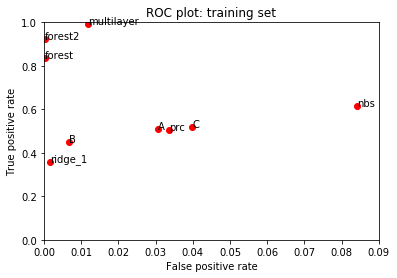

In [136]:
fits = [ logistic_performance,logistic_performance2,logistic_performance3,prc_performance,
        nbs_performance, ridge_performance_1, forest_performance,forest_performance2, multilayer_performance ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 0.09, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()